# Comparison between allelic rates and chromVAR scores

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [6]:
# local
sys.path.append('..')
from utils import settings

## Global variables

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Plot settings

In [8]:
SAVE_PLOTS = True

In [9]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [10]:
PLOT_DIRECTORY = 'figures/chromvar'
if not os.path.exists(PLOT_DIRECTORY):
    os.makedirs(PLOT_DIRECTORY)

## Load processed anndata

In [11]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

In [12]:
LINEAGES = adata_total.obs['annotation'].cat.categories.tolist() + ['Ubiquitous']

LINEAGE_COLORS = dict(zip(
    LINEAGES,
    adata_total.uns['annotation_colors'].tolist()))
LINEAGE_COLORS['Ubiquitous'] = 'gray'

Load anndata with GP estimates

In [13]:
df_all = pd.DataFrame()
adatas_allelic = dict()

for exp_id in settings.F1_EXP_IDS:
    # all tested peaks
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = adata.var
    adata_var['exp_id'] = exp_id
    adata_var['base_rate'] = (adata.X.A.sum(0) / adata.layers['allelic_total'].A.sum(0)).ravel()
    
    # with GP estimates
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts_processed.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = pd.merge(adata_var, adata.var['qdiff_10'], left_index=True, right_index=True, how='outer', sort=False)
    
    adata_var = adata_var.reset_index()
    df_all = pd.concat([df_all, adata_var], ignore_index=True)
    adatas_allelic[exp_id] = adata

In [14]:
  def vcorrcoef(X, y, method='pearson'):
    if method not in ['pearson', 'spearman']:
        raise ValueError('Unrecognized correlation method %s' % method)
    
    if method == 'spearman':
        X = pd.DataFrame(X).rank(axis=1).to_numpy()
        y = pd.DataFrame(y).rank(axis=1).to_numpy()
        
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r    

def compute_top_tfs(exp_id, peak, method='pearson', n_top=10):
    peak_scores = pd.Series(vcorrcoef(
        X=chromvar_scores[adatas_allelic[exp_id].obs_names].to_numpy(), 
        y=adatas_allelic[exp_id][:, peak].layers['gp_post_mean'].T,
        method=method),
    index=chromvar_scores.index)

    return peak_scores.loc[peak_scores.abs().sort_values(ascending=False).index[:n_top]]
    

def plot_chromvar_correlation(exp_id, peak, peak_scores, annotation, figsize=(3, 4), gridspec_kw={'width_ratios': [0.2, 0.8]}, s=100):
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw=gridspec_kw)
    
    ax = axes[0]
    peak_scores.abs().sort_values().plot.barh(ax=ax, color='dimgrey')
    ax.set_yticklabels(reversed(annotation.index.tolist()))
    sns.despine()
    tf_ids = np.flip(np.arange(peak_scores.size))
    sign_pos = 1.2 * peak_scores.abs().max()
    
    # positive correlation = same direction as maternal imbalance
    mask = peak_scores > 0
    ax.scatter(
        sign_pos * np.ones(mask.sum()), 
        tf_ids[mask], 
        marker=r'$+$', 
        s=15,
        c=np.atleast_2d(plt.cm.coolwarm(1.0)).repeat(mask.sum(), 0))
    
    # negative correlation = direction towards paternal
    mask = peak_scores < 0
    ax.scatter(
        sign_pos * np.ones(mask.sum()), 
        tf_ids[mask], 
        marker=r'$-$', 
        s=15,
        c=np.atleast_2d(plt.cm.coolwarm(0.0)).repeat(mask.sum(), 0))
    ax.set(
        xlabel='Pearson\'s r',
        ylim=[ax.get_ylim()[0], ax.get_ylim()[1]+0.25])
    
    # plot lineage annotation
    ax = axes[1]
    df = annotation
    for i in range(df.shape[0]):
        ax.plot([0, df.shape[1]], [i, i], c='lightgrey', linewidth=0.5, alpha=0.7)
        
    for i, c in enumerate(df):
        color = np.asarray(['#FFFFFF' for i in range(df.shape[0])])
        color[df[c]] = LINEAGE_COLORS[c]
        ax.scatter(np.ones(df.shape[0])*i, range(df.shape[0]), c=np.flip(color), s=s)

    ax.set(
        xlim=[ax.get_xlim()[0], df.shape[1]-0.5],
        ylim=[ax.get_ylim()[0], ax.get_ylim()[1]+0.25],
        xticks=range(df.shape[1]),
        yticks=range(df.shape[0]), yticklabels=[])
    sns.despine(ax=ax)
    
    labels = df.columns.to_numpy()
#     avg_label_len = df.columns.str.len().to_numpy().mean()
#     long_labels = df.columns.str.len() > avg_label_len
#     labels[long_labels] = df.columns[long_labels].str.replace(' ', '\n')
    ax.set_xticklabels(labels=labels, rotation=330, ha="right")
    ax.tick_params(labelbottom=False,labeltop=True)
    sns.despine(ax=ax, top=False, bottom=True, trim=True)
    
    return fig

def plot_chromvar_activity(exp_id, TF_list, TF_names=None, method='pearson', colorbar_q=0.05, **relplot_kwargs):
    if TF_names is None:
        TF_names = TF_list
    df = chromvar_scores.loc[TF_list, adatas_allelic[exp_id].obs_names].T
    df['UMAP1'] = adatas_allelic[exp_id].obsm['X_umap'][:, 0]
    df['UMAP2'] = adatas_allelic[exp_id].obsm['X_umap'][:, 1]

    df = df.melt(id_vars=['UMAP1', 'UMAP2'])
    df.columns = ['UMAP1', 'UMAP2', 'TF', 'chromVAR']
    df['TF'] = df['TF'].replace(dict(zip(TF_list, TF_names)))
    vmin = np.quantile(df['chromVAR'], colorbar_q)
    vmax = np.quantile(df['chromVAR'], 1-colorbar_q)
    
    divnorm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

    bottom = matplotlib.cm.get_cmap('Blues_r', 128)
    top = matplotlib.cm.get_cmap('Greens', 128)
    newcolors = np.vstack((bottom(np.linspace(0, 0.95, 128)),
                           top(np.linspace(0.05, 1, 128))))
    cmap = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

    g = sns.relplot(
        x='UMAP1', y='UMAP2', 
        hue='chromVAR', col='TF', 
        data=df, 
        kind='scatter', 
        edgecolor=None, 
        col_wrap=5, 
        palette=cmap,
        hue_norm=divnorm,
        legend=False,
        **relplot_kwargs)
    g.set(xticks=[], yticks=[])
    for ax in g.fig.axes:
        ax.get_children()[0].set_rasterized(True)

    points = plt.scatter([], [], c=[], cmap=cmap, norm=divnorm)
    g.fig.subplots_adjust(right=.92)
    cax = g.fig.add_axes([.94, .25, .01, .5])
    cbar = g.fig.colorbar(points, cax=cax)
    cbar.set_label('chromVAR z-score')
    plt.show()
    return g

## Load chromVAR scores

In [15]:
def format_TF_names(name_list):
    out = list()
    for s in name_list:
        if '(DBD_' in s:
            out.append(s.split('(')[1].split(')')[0])
        else:
            out.append(s)
    return out

In [16]:
chromvar_scores = pd.read_csv(os.path.join(settings.DATA_DIR, 'chromvar', 'DermFAC.motifs.deviations.Zscore.txt'), sep='\t')

In [17]:
correlations = pd.read_csv(os.path.join(settings.DATA_DIR, 'chromvar', 'DermFAC.motifs.Pearson.txt'), sep='\t')

In [18]:
chromvar_scores.index = correlations['name']
chromvar_scores.columns = adata_total.obs_names

## Load annotation

In [19]:
annotation = pd.read_csv(os.path.join(settings.DATA_DIR, 'chromvar', 'DermFAC.motifs.anno.top10.txt'), sep='\t', names=['TF', 'lineage', 'peak'])

annotation.set_index(annotation['TF'], inplace=True)

for lineage in LINEAGES:
    annotation[lineage] = annotation['lineage'].str.contains(lineage).to_numpy()

In [20]:
annotation

,TF,lineage,peak,Epidermis,Fat body,Hemocytes,Midgut,Muscle,Nervous system,Primordium,Ubiquitous
TF,,,,,,,,,,,
ttk,ttk,"Primordium, Nervous system, Muscle, Midgut, Ep...",Peak1,True,False,False,True,True,True,True,False
gatae,gatae,"Primordium, Midgut",Peak1,False,False,False,True,False,False,True,False
bin,bin,Muscle,Peak1,False,False,False,False,True,False,False,False
usp,usp,"Primordium, Nervous system, Midgut",Peak1,False,False,False,True,False,True,True,False
sna,sna,"Primordium, Nervous system",Peak1,False,False,False,False,False,True,True,False
pho,pho,Ubiquitous,Peak1,False,False,False,False,False,False,False,True
h,h,"Primordium, Nervous system, Midgut",Peak1,False,False,False,True,False,True,True,False
lola,lola,"Primordium, Nervous system",Peak1,False,False,False,False,False,True,True,False
slp1,slp1,"Primordium, Nervous system, Muscle, Midgut, Ep...",Peak1,True,False,False,True,True,True,True,False


## Plot

In [21]:
exp_id = 'SS157'
peak = 'chr3R_22877489_22878489'
peak_cnt = 1

[3.  1.5]


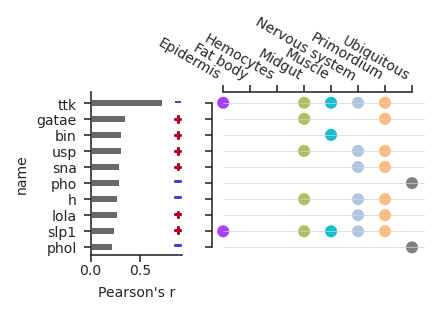

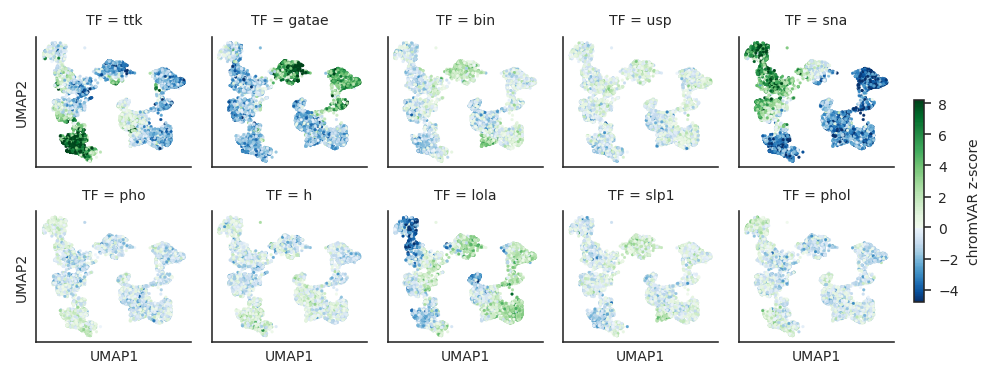

[7.  2.8]


In [22]:
peak_scores = compute_top_tfs(exp_id, peak)

df = annotation.query('peak == "Peak%d"' % peak_cnt)[LINEAGES]
with plt.rc_context({'xtick.major.pad': 1}):
    fig = plot_chromvar_correlation(exp_id, peak, peak_scores=peak_scores, annotation=df, figsize=(3, 1.5), gridspec_kw={'width_ratios': [0.3, 0.7]}, s=25)
print(fig.get_size_inches())
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/%s_%s_chromvar_correlation.svg' % (exp_id, peak), dpi=350)
    
g = plot_chromvar_activity(exp_id, peak_scores.index, df.index, height=1.4, aspect=1, s=2, colorbar_q=0.01)
print(g.fig.get_size_inches())
if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/%s_%s_chromvar_activities.svg' % (exp_id, peak), dpi=350)

In [23]:
exp_id = 'SS157'
peak = 'chr2R_13675707_13676707'
peak_cnt = 2

[3.  1.5]


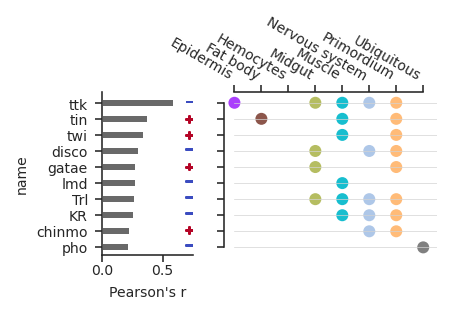

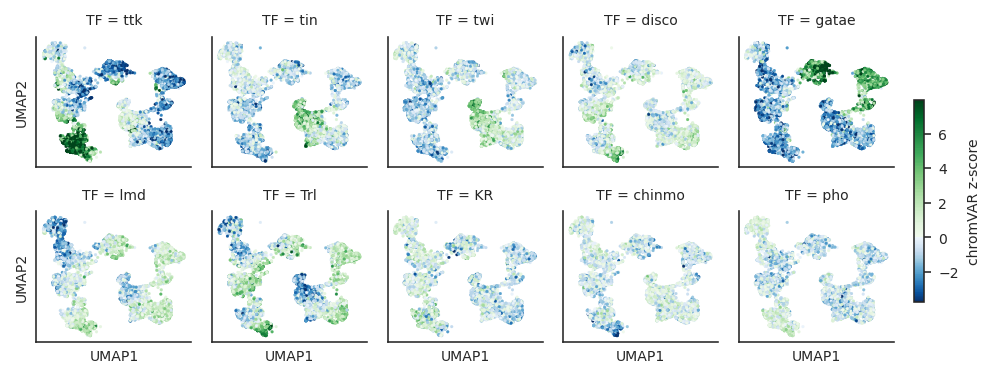

[7.  2.8]


In [24]:
peak_scores = compute_top_tfs(exp_id, peak)

df = annotation.query('peak == "Peak%d"' % peak_cnt)[LINEAGES]
with plt.rc_context({'xtick.major.pad': 1}):
    fig = plot_chromvar_correlation(exp_id, peak, peak_scores=peak_scores, annotation=df, figsize=(3, 1.5), gridspec_kw={'width_ratios': [0.3, 0.7]}, s=25)
print(fig.get_size_inches())
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/%s_%s_chromvar_correlation.svg' % (exp_id, peak), dpi=350)
    
g = plot_chromvar_activity(exp_id, peak_scores.index, df.index, height=1.4, aspect=1, s=2, colorbar_q=0.01)
print(g.fig.get_size_inches())
if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/%s_%s_chromvar_activities.svg' % (exp_id, peak), dpi=350)

In [25]:
exp_id = 'SS159'
peak = 'chr3R_20310056_20311056'
peak_cnt = 3

[3.  1.5]


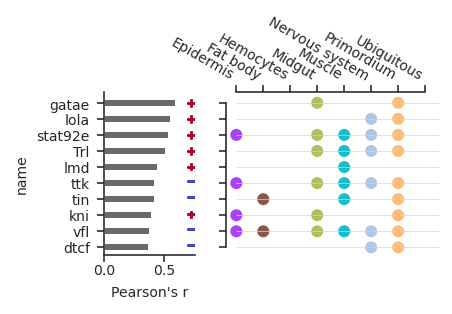

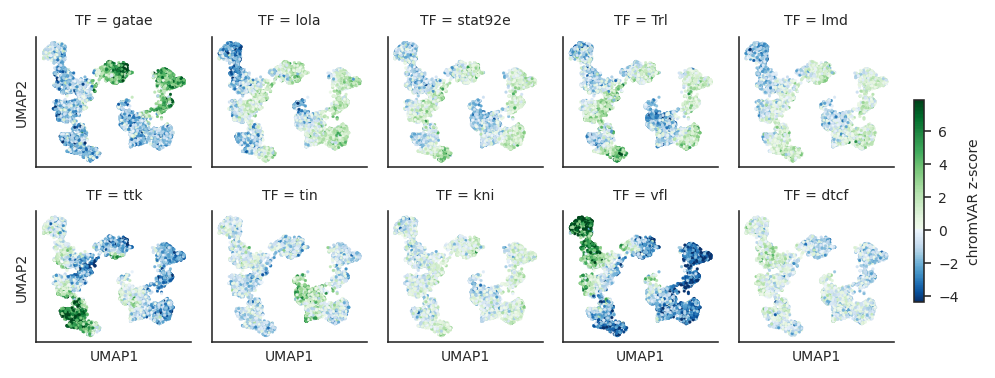

[7.  2.8]


In [26]:
peak_scores = compute_top_tfs(exp_id, peak)

df = annotation.query('peak == "Peak%d"' % peak_cnt)[LINEAGES]
with plt.rc_context({'xtick.major.pad': 1}):
    fig = plot_chromvar_correlation(exp_id, peak, peak_scores=peak_scores, annotation=df, figsize=(3, 1.5), gridspec_kw={'width_ratios': [0.3, 0.7]}, s=25)
print(fig.get_size_inches())
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/%s_%s_chromvar_correlation.svg' % (exp_id, peak), dpi=350)
    
g = plot_chromvar_activity(exp_id, peak_scores.index, df.index, height=1.4, aspect=1, s=2, colorbar_q=0.01)
print(g.fig.get_size_inches())
if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/%s_%s_chromvar_activities.svg' % (exp_id, peak), dpi=350)